# GWAS analysis for PD progression

Created 08/21/2018    
By Hirotaka Iwaki


### Predictors
1. Imputed variants with rsq > 0.8, maf > 0.05, and integer genotypes.
2. Variants in interest including 92 risk variants in the most recent meta-analysis, 
3. Genetic risk score composed of 92 risk variants.

### Outcomes

1. Binomial Outcomes:    
constipation(CONST), cognitive impairment (DEMENTIA), depressive mood (DEPR), dyskinesia (DYSKINESIAS), Hoehn Yahr Scale 3 or more (HY3), hyposmia (HYPOSMIA), insomnia (INS), motor fluctuations (MOTORFLUX), REM sleep behavior disorder (RBD), restless legs syndrome (RL), Modified Schwab and England Activities of Daily Living Scale 70 or less (SEADL70), daytime sleepiness (SLEEP)    


2. Contious Outcomes:    
Hoehn and Yahr scale (HY), MMSE, MoCA, SEADL, UPDRS_1/2/3/4/total    

### Analysis
For binomial outcomes;
1. **(cross)** cross-sectional analysis at baseline: logitsic regression
2. **(coxhm)** survival analysis for those who didn't have the symptom at the baseline: cox model with varying covariates.

For continous outcomes;
1. slope-analysis
    1. **(lnmxs)** Linear model with random intercept
    2. **(lncnx)** Conditional linear model orthogonal to time constant variable. 
2. intercept analysis
    1. **(lnmxi)** linear model with random intercept for repaeated obs. (linear model for the cohort with single obs)
    
### Covariates
1. SEX (FEMALE)
2. Age at diagnosis (AAO)
3. Years from diagnosis at baseline (BLDfDIAG)
4. Family History (FAMILY_HISTORY)
5. Years of Education (YEARSEDUC)
6. Treatment status (DOPA, AGNOIST)
7. Population structure (PC1-5)

### Meta-analysis
Fixed model

In [22]:
%%bash
# Predictors (Variants in interest)
cat predictor/_pos*.txt | LANG=C sort | uniq |sed '1 iPOS' > predictor/pos.txt
awk -F' ' '/rs/{print $1,$2,$3}' predictor/_snp* | LANG=C sort | sed '1 iPOS ID NearGene' | sed 's/ /\t/g' > predictor/snpInfo.txt
awk -F' ' '{print $1,$7}' predictor/_snpMETA5.txt > predictor/grs.txt

In [36]:
%%bash
# Create Phenotype files
# 1    Need to match phenotype ID and IID.
# 1.1    Extract IID from imputed file
rm t/_IDlist_imputed.txt
for DATASET in $(ls ../dataset);do
  cat /data/LNG/CORNELIS_TEMP/progression_GWAS/$DATASET/plink_files_hard/*.fam | sed "s/^/$DATASET:/g" | cut -f1 | cut -d " " -f1 | sed 's/:/'$'\t/g' >> t/_IDlist_imputed.txt
done
# 1.2    Creating HBS ID matching file. (No formal table so compare genotyping file)
module load plink
GNTYP_IN=/data/LNG/CORNELIS_TEMP/progression_GWAS/
plink --bfile data/HBS_original/pruned --bmerge $GNTYP_IN/pre_impute_data/HBS --make-bed --out t/V1
plink --bfile data/HBS_original/pruned --exclude t/V1-merge.missnp --make-bed --out t/V2
plink --bfile t/V2 --bmerge $GNTYP_IN/pre_impute_data/HBS --make-bed --out t/V3
plink --bfile t/V3 --genome --min 0.7 --out t/V4
mv t/V4.genome data/HBSIDmatch.txt
# 1.3    

In [27]:
%%bash
mkdir outGRS
for DATASET in $(ls ../dataset/);do
    mkdir outGRS/$DATASET
    mkdir outGRS/$DATASET/cross
    mkdir outGRS/$DATASET/coxhm
    mkdir outGRS/$DATASET/lnmxs
    mkdir outGRS/$DATASET/lncns
    mkdir outGRS/$DATASET/lnmxi
done

In [ ]:
#cross


In [9]:
%%bash
mkdir -p t
module load plink
DATASET=PPMI

[+] Loading plink  1.9.0-beta4.4  on cn3301 


PPMI N_COL_638345 N_SNP_638339 N_ITER_31


In [48]:
%%bash 
awk '$35 > 0.05{print $0}' t/allV_info.csv | cut -f2- > t/allV_info2.csv

In [49]:
import seaborn as sns
import matplotlib as mpl
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [51]:
df=pd.read_csv("t/allV_info2.csv", sep='\t', keep_default_na=False, na_values="")
df.shape

(108, 38)

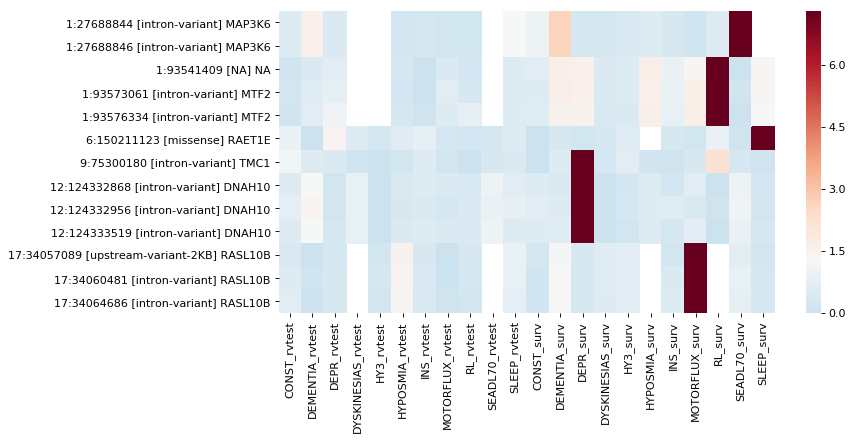

In [57]:
df_wo_slope = df.loc[:,[i for i in list(df) if not "slope" in i]]
df_wo_slope_sig = (df_wo_slope.iloc[:, 1:(df_wo_slope.shape[1]-6)] > 7.301).sum(axis=1)
df_wo_slop_less = df_wo_slope.loc[df_wo_slope_sig>0]
dft = df_wo_slop_less
dft_out = dft.iloc[:, 1:(dft.shape[1]-6)]
dft_out.index = dft['V1'] + " [" + dft['FXNCLASS'] + "] " + dft['SYMBOL']
dft_out.head()
fig=plt.figure(figsize=(10,5), dpi= 80, facecolor='w', edgecolor='k')
sns.heatmap(dft_out,cmap='RdBu_r', vmin=0, center=1.301, vmax=7.301)